# Anime LDA Topic Similarity Model

### Read data import

In [1]:
import mysql.connector as my_sql
from dotenv import load_dotenv
import os
import pandas as pd

### Read data

In [2]:
# Load environmental variables
load_dotenv()

True

In [3]:
def query_data():
    """
    Returns a dataframe with an anime's title and synopsis
    """
    
    mydb = my_sql.connect(
        host=os.getenv('DATABASE_HOST'),
        user=os.getenv('DATABASE_USER'),
        password=os.getenv('DATABASE_PASSWORD'),
        database=os.getenv('DATABASE_NAME')
    )
    
    mycursor = mydb.cursor()
    
    mycursor.execute('SELECT Title, Synopsis, MediaType, Genres, Rating FROM MAL_Anime_Details')

    df = pd.DataFrame(mycursor.fetchall(), columns=[
        'Title',
        'Synopsis',
        'MediaType',
        'Genres',
        'Rating'
    ])
    
    mycursor.close()
    
    return df

In [4]:
df = query_data()

df.head()

,Title,Synopsis,MediaType,Genres,Rating
0,Cowboy Bebop,"In the year 2071, humanity has colonized sever...",TV,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",R - 17+ (violence & profanity)
1,Cowboy Bebop: Tengoku no Tobira,"Another day, another bounty—such is the life o...",Movie,"Action,Drama,Mystery,Sci-Fi,Space",R - 17+ (violence & profanity)
2,Trigun,"Vash the Stampede is the man with a $$60,000,0...",TV,"Action,Sci-Fi,Adventure,Comedy,Drama,Shounen",PG-13 - Teens 13 or older
3,Witch Hunter Robin,Witches are individuals with special powers li...,TV,"Action,Mystery,Police,Supernatural,Drama,Magic",PG-13 - Teens 13 or older
4,Bouken Ou Beet,It is the dark century and the people are suff...,TV,"Adventure,Fantasy,Shounen,Supernatural",PG - Children


### Clean data imports

In [5]:
import re

### Clean data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17628 entries, 0 to 17627
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      17628 non-null  object
 1   Synopsis   17628 non-null  object
 2   MediaType  17628 non-null  object
 3   Genres     17628 non-null  object
 4   Rating     17628 non-null  object
dtypes: object(5)
memory usage: 688.7+ KB


In [7]:
pre_processed_df = df.copy()

In [8]:
pre_processed_df = pre_processed_df[pre_processed_df['MediaType'].isin(['TV', 'Movie', 'OVA'])]

In [9]:
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11865 entries, 0 to 11864
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      11865 non-null  object
 1   Synopsis   11865 non-null  object
 2   MediaType  11865 non-null  object
 3   Genres     11865 non-null  object
 4   Rating     11865 non-null  object
dtypes: object(5)
memory usage: 463.6+ KB


In [10]:
pre_processed_df = pre_processed_df.drop(['MediaType'], axis=1)

In [11]:
def filter_sources(text):
    """
    Removes the source of the synopsis from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the source.
    """
    
    new_text = re.sub('\(Source:.*\)', '', text, flags=re.IGNORECASE)
        
    new_text = re.sub('\[(Writt|from|Source).*\]', '', new_text, flags=re.IGNORECASE)
    
    return new_text.strip()

In [12]:
def filter_notes(text):
    """
    Removes the writers note from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the note.
    """
    
    new_text = re.sub('Note:', '', text, flags=re.IGNORECASE)
    
    
    return new_text.strip()

In [13]:
def filter_japanese_characters(text):
    """
    Removes japanese characters from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the japanese characters.
    """
    
    new_text = re.sub('/[\u3000-\u303F]|[\u3040-\u309F]|[\u30A0-\u30FF]|[\uFF00-\uFFEF]|[\u4E00-\u9FAF]|[\u2605-\u2606]|[\u2190-\u2195]|\u203B/g', '', text)
        
    return new_text.strip()

In [14]:
def filter_unwanted_text(text):
    """
    Removes unwanted tokens from the text
    
    Parameters
    ----------
    text: string
        The synopsis to filter out unwanted tokens.
    """
    
    no_sources_text = filter_sources(text)
    no_notes_text = filter_notes(no_sources_text)
    no_japanese_text = filter_japanese_characters(no_notes_text)

    return no_japanese_text

In [15]:
pre_processed_df["Synopsis"] = pre_processed_df["Synopsis"].apply(filter_unwanted_text)

In [16]:
pre_processed_df.shape

(11865, 4)

In [17]:
# Dropping rows with no real synopsis
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'No synopsis has been added for this series yet. Click here to update this information.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here.']
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.shape

(11227, 4)

In [18]:
# Dropping rows with non-useful synopsis
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Furukawa Taku film.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Film by Takashi Ito.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short animation by Taku Furukawa.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short film by Okamoto Tadanari.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short puppet animation movie by Tadahito Mochinaga.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short film by Hirano Ryou.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short film by Kurosaka Keita.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Unaired specials included in the Blu-ray and DVD release.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Recap episode.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Movie based on the 1985 TV anime with an original plot.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A mix of animation and live-action.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Film by Tanaami Keiichi.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short animation by Komazaki Tomomi.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short movie from 1931.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short experimental animation from Yoji Kuri.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short specials added to DVDs and Blu-rays.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Special episodes added to DVDs and Blu-rays.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Puppet animation by Tadanari Okamoto.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'BD/DVD specials.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A special Christmas episode.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Part of Anime Tamago 2018.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A film by Keiichi Tanaami.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Experimental animation by Manabe Hiroshi, member of the Animation Sannin no Kai pioneer group of independent animation.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short film by Yoriko Mizushiri.']
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.shape

(11128, 4)

In [19]:
# import collections

# collections.Counter(list(pre_processed_df[pre_processed_df['Synopsis'].duplicated()]['Synopsis'])).most_common()

### Process data imports

In [20]:
from gensim.models import Phrases
import spacy
from spacy.lang.en import English
import string
import unidecode

### Process data

In [21]:
nlp = spacy.load("en_core_web_lg")

In [22]:
spacy_df = pre_processed_df.copy()

In [23]:
def remove_people(text):
    """
    Removes character names from synopsis (identified through Named Entity Recognition).
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the character names.
    """
    
    text_nlp = nlp(text)
    
    for ent in text_nlp.ents:
        if(ent.label_ == 'PERSON'):
            text = text.replace(ent.text, '')
            
    return text

In [24]:
def remove_non_alphabetical_characters(text):
    """
    Cleans text, keeping only alphabetical characters
        
    Parameters
    ----------
    token: str
        Word being processed

    Returns
    -------
    str:
        Cleaned string
    """
    
    text = str(text).translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    split_text = [
        ''.join([letter for letter in word if letter.isalpha()])
        for word in text.split()
    ]
    
    cleaned_text = ' '.join(split_text)
    
    return cleaned_text

In [25]:
def prepare_text(text):
    """
    Lemmatizes text using spaCy
        
    Parameters
    ----------
    text: str
        Text being processed

    Returns
    -------
    str:
        Lemmatized text
    """
    
    if text == '':
        return text
    
    # Remove people
    cleaned_text = remove_people(text)
    
    # Clean  
    cleaned_text = remove_non_alphabetical_characters(cleaned_text)
    
    # Tokenize
    tokens = nlp(cleaned_text.lower())
    
    custom_stop_list = [
    'episode',
    'series',
    'short',
    'anime',
    'story',
    'film',
    'feature',
    'character',
    'special',
    'movie',
    'animation',
    'original',
    'release',
    'manga',
    'ova',
    'scene',
    'animate',
    'show',
    'volume',
    'adaptation',
    'video',
    'manga',
    'crossover',
    'season'
    ]
    
    # Lemmatize
    lemmatized_text = ' '.join([token.lemma_ for token in tokens if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB' or token.pos_ == 'ADV' or token.dep_ == 'ROOT') and token.lemma_ not in custom_stop_list])
    
    # Remove short words (<= 2)
    removed_short_words = [x for x in lemmatized_text.split() if len(x) > 2]
    
    full = ' '.join(removed_short_words)
    
    return unidecode.unidecode(full)

In [26]:
def seperate_genres(text):
    """
    Removes punctuation from genres and replaces spaces with underscores. Lastly, returns the genres as a string 
    seperated by a space
    
    Parameters
    ----------
    text: str
        Genres being processed.
    """
    
    split_text = sorted(text.split(','))
    split_text_no_punct = [x.translate(str.maketrans('', '', string.punctuation)) for x in split_text]
    split_text_no_space = [x.replace(' ', '_') for x in split_text_no_punct]
    
    return ' '.join(split_text_no_space).lower()

In [27]:
def merge_ratings(text):
    """
    
    """
    
    split_text = sorted(list(map(lambda x: x.replace(' ', '_'), text.split(','))))
    split_text = [
        ''.join([letter for letter in word if letter.isalpha() or letter == '_'])
        for word in split_text
    ]
    
    return ' '.join(split_text).lower()

In [28]:
spacy_df['Genres'] = spacy_df['Genres'].apply(seperate_genres)

In [29]:
spacy_df['Rating'] = spacy_df['Rating'].apply(merge_ratings)

In [30]:
spacy_df['Corpus'] = spacy_df['Synopsis']
spacy_df = spacy_df[['Title', 'Corpus', 'Genres', 'Rating']]

spacy_df['Corpus'] = spacy_df['Corpus'].apply(prepare_text)

In [31]:
spacy_df.shape

(11128, 4)

In [32]:
spacy_df = spacy_df[spacy_df['Corpus'].str.split().apply(len) > 0]
spacy_df.reset_index(inplace = True, drop = True) 

In [33]:
spacy_df.shape

(10989, 4)

In [34]:
english_nlp = English()
english_nlp.add_pipe(english_nlp.create_pipe('sentencizer'))
    
def split_doc_to_sentence(doc):
    """
    
    """
    
    split_doc = english_nlp(doc)
    
    return [sent.string.strip() for sent in split_doc.sents]

In [35]:
def create_unigrams(corpus_list):
    """
    
    """

    # Convert document to list of sentences     
    list_of_list = list(map(lambda x: split_doc_to_sentence(x), corpus_list))
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    # Flatten all the sentences in the corpus (multiple sentences in multiple documents => multiple sentences 
    # in 1 document) 
    unigram_sentences = flatten(list_of_list)

    # Split sentences to words     
    unigrams = [x.split() for x in unigram_sentences]

    return unigrams
    
def create_ngrams(grams, stop):
    """
    
    """

    ngram_model = Phrases(grams)

    ngram_sentences = []
    
    for gram in grams:
        ngram_sentence = u' '.join(ngram_model[gram])
        ngram_sentences.append(ngram_sentence)

    if stop:
        return ngram_sentences
    else:
        return [x.split() for x in ngram_sentences]

In [36]:
def add_ngrams_genres_to_documents(df):
    unigram_words = create_unigrams(df['Corpus'].tolist())
    bigram_words = create_ngrams(grams=unigram_words, stop=False)
    trigram_sentences = create_ngrams(grams=bigram_words, stop=True)
    
    df.reset_index(inplace = True, drop = True) 

    for i, synopsis in enumerate(trigram_sentences, start=0):
        df['Corpus'][i] = (synopsis + ' ' + df['Genres'][i] + ' ' + (df['Rating'][i] if df['Rating'][i] != 'none' else '')).strip()

In [37]:
add_ngrams_genres_to_documents(spacy_df)

In [38]:
spacy_df.shape

(10989, 4)

In [39]:
save_df = spacy_df.copy()

In [66]:
spacy_df = save_df
spacy_df.shape

(10989, 4)

In [67]:
spacy_df = spacy_df[spacy_df['Corpus'].str.split().apply(len) >= 20]
spacy_df.reset_index(inplace = True, drop = True) 

In [68]:
spacy_df.shape

(7302, 4)

In [69]:
# import collections

# collections.Counter(list(spacy_df[spacy_df['Corpus'].duplicated()]['Corpus'])).most_common()

### Topic Modeling

In [70]:
from collections import defaultdict
from gensim import corpora, models

In [71]:
def create_LDA_tools(documents):
    """
    
    """
    
    texts = [
        [token for token in text.split()]
        for text in documents
    ]

    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=30, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return texts, dictionary, corpus

In [72]:
texts, dictionary, corpus = create_LDA_tools(spacy_df['Corpus'])

In [73]:
def get_coherence_scores(dictionary, corpus, texts, start, stop, step):
    """
    
    """
    
    mallet_path = os.getenv('MALLET_PATH_')
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, stop, step):
        model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=1000, optimize_interval=10)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [74]:
model_list, coherence_values = get_coherence_scores(dictionary=dictionary, corpus=corpus, texts=texts, start=14, stop=24, step=1)

### Visual analysis imports

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

### Visual analysis

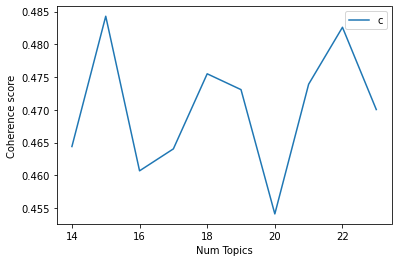

In [76]:
start=14; stop=24; step=1;
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [77]:
def get_optimal_model(coherence_values, model_list, print_scores=True):
    max_value = max(coherence_values)
    max_index = coherence_values.index(max_value)
    print('Optimal model found at index', max_index)
    optimal_model = model_list[max_index]
    model_topics = optimal_model.show_topics(formatted=False)
    
    if print_scores:
        for i, (m, cv) in enumerate(zip(x, coherence_values)):
            print("Index", i, ":", "Num Topics =", m, "has Coherence Value of", round(cv, 4))
            
    return optimal_model, max_index

In [78]:
optimal_model, optimal_model_index = get_optimal_model(coherence_values, model_list, print_scores=True)
pprint.pprint(optimal_model.show_topics())

Optimal model found at index 1
Index 0 : Num Topics = 14 has Coherence Value of 0.4644
Index 1 : Num Topics = 15 has Coherence Value of 0.4843
Index 2 : Num Topics = 16 has Coherence Value of 0.4607
Index 3 : Num Topics = 17 has Coherence Value of 0.464
Index 4 : Num Topics = 18 has Coherence Value of 0.4755
Index 5 : Num Topics = 19 has Coherence Value of 0.4731
Index 6 : Num Topics = 20 has Coherence Value of 0.4541
Index 7 : Num Topics = 21 has Coherence Value of 0.4739
Index 8 : Num Topics = 22 has Coherence Value of 0.4826
Index 9 : Num Topics = 23 has Coherence Value of 0.47
[(13,
  '0.041*"adventure" + 0.028*"island" + 0.026*"fantasy" + 0.020*"comedy" + '
  '0.018*"find" + 0.015*"friend" + 0.015*"pg__children" + 0.013*"dragon" + '
  '0.012*"world" + 0.012*"kids"'),
 (9,
  '0.032*"war" + 0.027*"military" + 0.024*"action" + '
  '0.013*"r___violence__profanity" + 0.012*"drama" + 0.010*"force" + '
  '0.010*"battle" + 0.010*"country" + 0.010*"scifi" + 0.009*"year"'),
 (14,
  '0.045*"

In [ ]:
# # # Tried different ones and I liked this one the most
# optimal_model = model_list[20]
# optimal_model_index = 20

In [ ]:
def dominant_document_topics(ldamodel=optimal_model, corpus=corpus, texts=texts):
    """
    Find the dominant topic in each document
    
    
    """
    
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    titles = pd.Series(spacy_df['Title'])
    contents = pd.Series(spacy_df['Corpus'])
    doc_topics_df = pd.concat([doc_topics_df, titles, contents], axis=1)
    return doc_topics_df

In [ ]:
df_topic_docs_keywords = dominant_document_topics(ldamodel=optimal_model, corpus=corpus, texts=texts)

In [ ]:
df_topic_docs_keywords.head(15)

In [ ]:
def most_representative_document_by_topic(dominant_topics):
    """
    Find the most representative documents for each topic
    """
    
    # Group top 5 sentences under each topic
    doc_topics_sorteddf_mallet = pd.DataFrame()

    doc_topics_outdf_grpd = dominant_topics.groupby('Dominant_Topic')

    for i, grp in doc_topics_outdf_grpd:
        doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)

    # Reset Index    
    doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Title", "Text"]

    # Show
    return doc_topics_sorteddf_mallet

In [ ]:
doc_topics_sorteddf_mallet = most_representative_document_by_topic(df_topic_docs_keywords)
doc_topics_sorteddf_mallet.head(17)

In [ ]:
def topic_distribution(dominant_topics):
    """
    Topic distribution across documents
    """
    
    # Number of Documents for Each Topic
    topic_counts = dominant_topics['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = dominant_topics[['Dominant_Topic', 'Topic_Keywords']]

    # Concatenate Column wise
    df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

    # Change Column names
    df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

    # Show
    return df_dominant_topics

In [ ]:
topic_distribution(df_topic_docs_keywords).head(17)

In [53]:
import pyLDAvis.gensim
import gensim
import warnings

In [55]:
warnings.filterwarnings("ignore")
pyLDAvis.enable_notebook()

In [79]:
pyLDAvis.gensim.prepare(models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model), corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.191489  0.010432       1        1  11.800168
6     -0.187117  0.052402       2        1  10.167080
2      0.002364 -0.039699       3        1   8.891081
1     -0.172679 -0.008580       4        1   8.398612
10     0.076140 -0.170344       5        1   7.145718
8      0.154832  0.102223       6        1   6.791591
11     0.127399 -0.062972       7        1   6.414715
7     -0.075107  0.096450       8        1   5.520688
12    -0.066354 -0.168016       9        1   5.501641
5      0.204702 -0.042849      10        1   5.281557
4     -0.170332 -0.061921      11        1   5.034842
9     -0.131343  0.163318      12        1   5.024501
14     0.026208  0.168209      13        1   5.009146
0      0.127560  0.079813      14        1   4.786776
13    -0.107761 -0.118467      15        1   4.231884, topic_info=                     Term         Freq        Total Category  logprob  loglift
202                school  2409.000000  2409.000000  Default  30.0000  30.0000
1423               hentai   872.000000   872.000000  Default  29.0000  29.0000
1427           rx__hentai   856.000000   856.000000  Default  28.0000  28.0000
2               adventure  2356.000000  2356.000000  Default  27.0000  27.0000
138                 magic  1030.000000  1030.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
236                search    61.336038   366.100903  Topic15  -5.1900   1.3760
524                  time    72.488045  1387.601651  Topic15  -5.0230   0.2106
112   pg__teens__or_older    79.179250  3280.042950  Topic15  -4.9347  -0.5614
24                  leave    64.681640   848.578829  Topic15  -5.1369   0.5884
315                  save    63.566440   714.789445  Topic15  -5.1543   0.7426

[882 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
434       1  0.019328  ability
434       2  0.105231  ability
434       3  0.208315  ability
434       4  0.079461  ability
434       5  0.006443  ability
...     ...       ...      ...
177      11  0.034237    young
177      12  0.076691    young
177      13  0.034237    young
177      14  0.019173    young
177      15  0.017803    young

[4814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 2, 11, 9, 12, 8, 13, 6, 5, 10, 15, 1, 14])

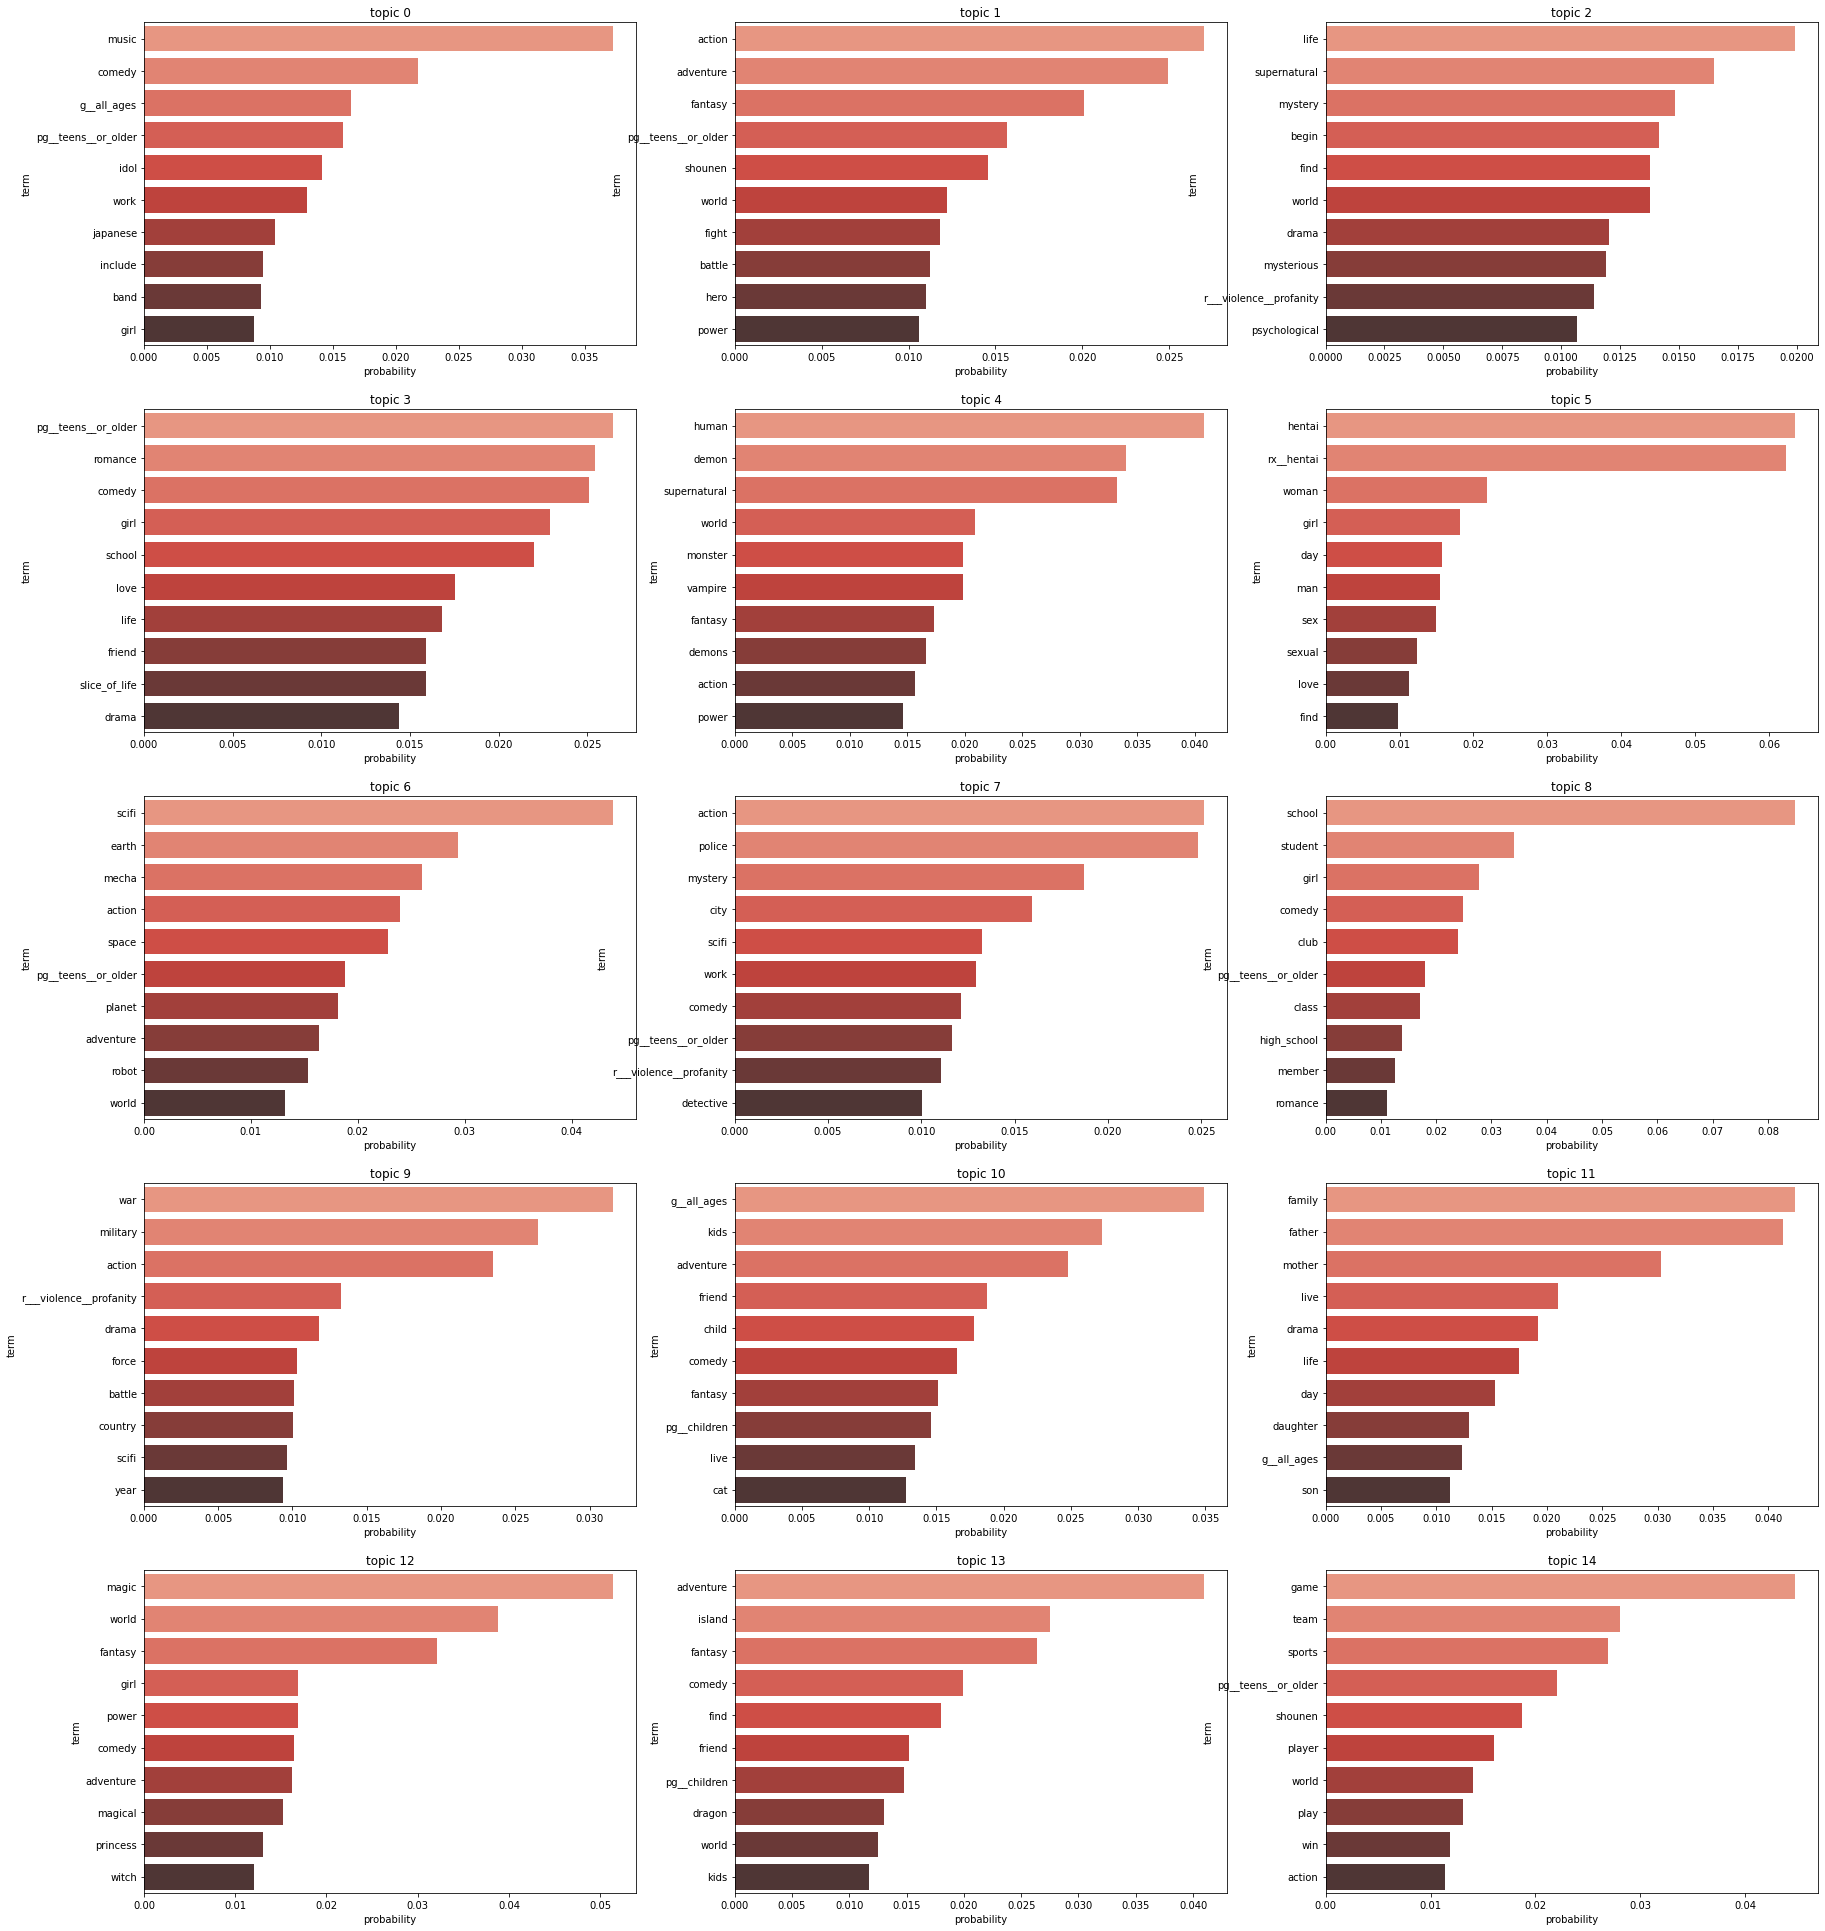

In [80]:
fiz=plt.figure(figsize=(30,70))

for i in range(optimal_model_index + start):
    df_plt=pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(10,3,i+1)
    plt.title('topic '+str(i))
    sns.barplot(x='prob', y=df_plt.index, data=df_plt, palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

### Similarity metric imports

In [81]:
import numpy as np
from scipy.spatial import distance

### Similarity metric

In [82]:
def create_topic_matrix(model, corpus):
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in model[corpus]])
    
    return doc_topic_dist

In [83]:
doc_topic_dist = create_topic_matrix(optimal_model, corpus)

In [84]:
def get_js_distances(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

In [85]:
def get_title_from_index(index, df):
    """
    Returns a title from an index in a dataframe
    
    index: int
        The index of the title.
    df: pandas.Dataframe
        Dataframe the title lies within.
    """
    
    title = df[df.index == index]['Title'].values[0]
    return title

def get_index_from_title(title, df):
    """
    Returns a title's index in a dataframe
    
    title: string
        Title to find its index.
    df: pandas.Dataframe
        Dataframe the title lies within.
    """
    
    index = df[df['Title'] == title].index.values[0]
    return index

def recommend(matrix, title = None, synopsis = None, synopsis_genres = None, measure="similarity", k=10):
    """
    
    """
    
    if title is None and synopsis is None:
        return
    
    score_indexes = []
    title_indexes = []
    
    if title is not None:
        title_index = get_index_from_title(title, spacy_df)
        jensen_shannon_scores = get_js_distances(matrix[title_index], matrix)
        most_similar_indexes = np.array(jensen_shannon_scores).argsort()
        
        if measure == 'similarity':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=True))
            score_indexes = sorted_js_scores[1:k + 1]
            title_indexes = most_similar_indexes[1:k + 1]
        elif measure == 'distance':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=False))
            score_indexes = sorted_js_scores[:k]
            title_indexes = most_similar_indexes[::-1][:k]
        
    elif synopsis is not None:
        cleaned_synopsis = prepare_text(synopsis)
        
        if synopsis_genres is not None:
            cleaned_synopsis = cleaned_synopsis + ' ' + seperate_genres(synopsis_genres)
            
        cleaned_synopsis_split = cleaned_synopsis.split()
        synopsis_bow = dictionary.doc2bow(cleaned_synopsis_split)
        synopsis_distribution = np.array([tup[1] for tup in optimal_model[synopsis_bow]])
        jensen_shannon_scores = get_js_distances(synopsis_distribution, matrix)
        most_similar_indexes = np.array(jensen_shannon_scores).argsort()
        
        if measure == 'similarity':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=True))
            score_indexes = sorted_js_scores[1:k + 1]
            title_indexes = most_similar_indexes[1:k + 1]
        elif measure == 'distance':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=False))
            score_indexes = sorted_js_scores[:k]
            title_indexes = most_similar_indexes[::-1][:k]
    
    # (title name, jensen shannon score, topic distribution)
    titles_with_weights = [(get_title_from_index(title_idx, spacy_df), score_indexes[idx], matrix[title_idx]) for idx, title_idx in enumerate(title_indexes)]
    return titles_with_weights

In [87]:
# Predict through title
recommend(doc_topic_dist, title = 'Shingeki no Kyojin', measure = 'similarity', k = 10)

[('Shingeki no Kyojin Season 3',
  0.7930155153661314,
  array([0.00130396, 0.00777063, 0.00982598, 0.02240538, 0.27952577,
         0.00118281, 0.01200538, 0.02888205, 0.00748357, 0.60915523,
         0.0017829 , 0.00366065, 0.00122158, 0.00091698, 0.01287715])),
 ('Trinity Blood',
  0.7914387014179511,
  array([0.00251785, 0.00596775, 0.01209549, 0.0111414 , 0.42848728,
         0.00090838, 0.00618716, 0.0600915 , 0.00119804, 0.45265986,
         0.00440208, 0.00584417, 0.00397099, 0.00373706, 0.000791  ])),
 ('Fullmetal Alchemist: Brotherhood',
  0.7895773725080875,
  array([0.00632794, 0.04483614, 0.01378921, 0.0178878 , 0.36228868,
         0.01832318, 0.02261238, 0.00454196, 0.00309456, 0.42096381,
         0.0050185 , 0.02222137, 0.00625581, 0.04747937, 0.00435928])),
 ('Ultraviolet: Code 044',
  0.7895062961519067,
  array([0.00888428, 0.02316062, 0.00659998, 0.02787513, 0.22229347,
         0.00867937, 0.0603779 , 0.04550785, 0.00263833, 0.54602309,
         0.01637322, 0.0195

In [88]:
# Predict through synopsis
recommend(doc_topic_dist, synopsis = 'It is the year 20XX. Earth was assaulted by monsters that would come to be known as "the Enemy of Humanity." In order to deal with this threat, special schools composed of teenagers with extraordinary abilities were formed. These people, who came to be known as "the Talented," had abilities that could defy the rules of reality. Among these people with supernatural powers was an outlier, an individual who was sent to one of these schools despite having no innate special abilities whatsoever. This is the story of our protagonist, who attempts to defeat the Enemies of Humanity through the use of intelligence and manipulation alone.', synopsis_genres='super_power,psychological,supernatural,thriller,shounen', measure = 'similarity', k = 5)

[('Megami Kouhosei',
  0.7962384453620941,
  array([0.00346312, 0.01029396, 0.02080796, 0.00906704, 0.24938117,
         0.00124942, 0.588342  , 0.00756554, 0.07881971, 0.00105577,
         0.00605476, 0.00178107, 0.00129037, 0.00305434, 0.01777377])),
 ('Hametsu no Mars',
  0.7961975610142988,
  array([0.0016574 , 0.0123866 , 0.08025203, 0.01843945, 0.31764551,
         0.00401314, 0.5448125 , 0.00157433, 0.00951199, 0.0012704 ,
         0.00226616, 0.00214314, 0.00155269, 0.00116552, 0.00130913])),
 ('Gaist Crusher',
  0.7942934928857369,
  array([0.00494976, 0.02365613, 0.02377814, 0.00699714, 0.27296413,
         0.00178576, 0.58751102, 0.01677539, 0.02918488, 0.00150899,
         0.00269176, 0.00254564, 0.02271183, 0.00138442, 0.001555  ])),
 ('Blue Seed 2',
  0.7937974082866409,
  array([0.03263429, 0.01115849, 0.10940585, 0.03082854, 0.34341812,
         0.00345364, 0.30602683, 0.07280108, 0.03914717, 0.00291837,
         0.00520584, 0.00492325, 0.02086297, 0.00267745, 0.0145381

### Save data

In [89]:
spacy_df = spacy_df[['Title']]
spacy_df.to_pickle('../anime_recs_synopsis/model_files/spacy_df.pkl')

In [90]:
np.save('../anime_recs_synopsis/model_files/doc_topic_dist.npy', doc_topic_dist)

In [91]:
dictionary.save('../anime_recs_synopsis/model_files/dictionary')

In [92]:
optimal_model.save('../anime_recs_synopsis/model_files/lda.model')